# **Homework 2**

## 1. Preliminary Steps

### 1.1 Install dependencies 

In [ ]:
!python -m pip install 'Pillow-SIMD'
!python -m pip install 'tqdm'
!python -m pip install 'hpbandster'

     |████████████████████████████████| 634kB 6.8MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110370 sha256=6d7a067ba1409f31fdf3ba83ac86fd607fe853eab8daf06f76eb8c2a7a53a88c
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD
     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 972kB 34.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.17-cp36-cp36m-linux_x86_64.whl size=2880669 sha256=9e5b6bc3785df6a4c3057032f180971d8bfc7e711e03dd6fc85f93a88e458dc4
  Stored in directory: /root/.cache/pip/wheels/96/57/d1/1ddcabb999aecbd5af6bf458cc156dcb2f684307ea3ddc11a1
Successfully built ConfigSpace
  Created wheel for hpband

### 1.2 Import Libraries


In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import copy

#from torch_lr_finder import LRFinder

### 1.3 Clone repository

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
	!git clone https://github.com/rm-wu/Homework2-Caltech101.git
	!mv 'Homework2-Caltech101' 'Caltech101'

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9280, done.
remote: Total 9280 (delta 0), reused 0 (delta 0), pack-reused 9280
Receiving objects: 100% (9280/9280), 129.49 MiB | 52.49 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (9149/9149), done.


In [ ]:
# TODO: Move this into the Caltech File

from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):
	# open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
	with open(path, 'rb') as f:
		img = Image.open(f)
		return img.convert('RGB')


class Caltech(VisionDataset):
	def __init__(self, root, split='train', transform=None, target_transform=None):
		super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

		if split not in ['train', 'test']:
			raise ValueError("split must be equal to 'train' or 'test'")
		print(f"Split : {split}")

		if os.path.isdir(self.root):
			with open(os.path.join(self.root, f"{split}.txt")) as f:
				file_list = f.readlines()
		else:
			raise ValueError(f"{self.root} is not a directory")

		#remove class "BACKGROUND_Google"
		file_list = [f.strip('\n') for f in file_list if not f.startswith("BACKGROUND_Google/")]

		self.categories = set([f.split('/')[0] for f in file_list])
		self.categories = sorted(list(self.categories))

		self.y = []
		self.index = []
		self.images = []

		for (i, c) in enumerate(self.categories):
			#print(c)
			files = [f.split('/')[1].split('_')[1] for f in file_list if f.startswith(f"{c}/")]
			n = len(files)
			#print(len(files))
			images = []
			for f in files:
				img_name = os.path.join(self.root, 
										"101_ObjectCategories", 
										c, 
										f"image_{f}")
				image = pil_loader(img_name)
				images.append(image)
			self.index.extend(files)
			self.images.extend(images)
			self.y.extend(n*[i])
			#print(f"{split} : {len(self.images)}")

		#print(len(self.index))
		#self.split = file_list
		# This defines the split you are going to use
		# (split files are called 'train.txt' and 'test.txt')

		'''
		- Here you should implement the logic for reading the splits files and accessing elements
		- If the RAM size allows it, it is faster to store all data in memory
		- PyTorch Dataset classes use indexes to read elements
		- You should provide a way for the __getitem__ method to access the image-label pair
		  through the index
		- Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class)
		'''

	def __getitem__(self, idx):
		'''
		__getitem__ should access an element through its index
		Args:
			index (int): Index

		Returns:
			tuple: (sample, target) where target is class_index of the target class.
		'''
		#print(idx, self.index[idx], self.y[idx], self.categories[self.y[idx]])
		# img_name = os.path.join(self.root, "101_ObjectCategories",
		# 						self.categories[self.y[idx]],
		# 						f"image_{self.index[idx]}")
		# image = pil_loader(img_name)
		image = self.images[idx]
		label = self.y[idx]



		#image, label =

		# Provide a way to access image and label via index
		# Image should be a PIL Image
		# label can be int

		# Applies preprocessing when accessing the image
		if self.transform is not None:
				image = self.transform(image)

		return image, label

	def __len__(self):
		'''
		The __len__ method returns the length of the dataset
		It is mandatory, as this is used by several other components
		'''
		length = len(self.index) # Provide a way to get the length (number of elements) of the dataset
		return length


### 1.4 Utils Function

#### 1.4.1 Training Funciton


In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss




def train_model(model, dataloader, config):
    # Best model values 
    best_model_w = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss  = 1e9 
    best_train = (0, 0)
    # Train/Validation logs 
    val_logs = {'loss':[], 'acc': []}
    train_logs = {'loss':[], 'acc': []}
    
    early_stopping = EarlyStopping(patience=5)#, verbose=True)

    
    cudnn.benchmark
    device = config['device']
    model.to(device)
    
    optimizer = config['optimizer']
    scheduler = config['scheduler'] if 'scheduler' in config else None
    criterion = config['criterion']
    

    iters = len(dataloader['train'])

    for epoch in range(config['num_epochs']):
        print(f"Epoch {epoch + 1}/{config['num_epochs']}", end=" ")
        if scheduler is not  None:
            print(f"lr : {scheduler.get_last_lr()}")
        else:
            print()
        print('=' * 50)

        for phase in ['train', 'val']:
            #print(phase)
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (images, labels) in enumerate(dataloader[phase]):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data) 

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = (running_corrects.double() / len(dataloader[phase].dataset)).item()

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            if phase == 'train':
                train_logs['loss'].append(epoch_loss)
                train_logs['acc'].append(epoch_acc)
            else:
                val_logs['loss'].append(epoch_loss)
                val_logs['acc'].append(epoch_acc)
                early_stopping(epoch_loss, model)

            print(f"{phase}\tLoss: {epoch_loss: .4f}\tAcc: {epoch_acc: .4f}")

            if phase == 'val' and epoch_loss < best_loss:
                print(f"new best val loss {epoch_loss: .4f}  (acc = {epoch_acc: .4f})")
                best_loss  = epoch_loss
                best_acc = epoch_acc
                best_train = (train_logs['loss'][-1], train_logs['acc'][-1])
                best_model_w = copy.deepcopy(model.state_dict())
            
        if early_stopping.early_stop:
            print("Early stopping")
            break
        print()

    print(f'Best val Loss: {best_loss:4f} with Acc: {best_acc:4f}')
    print(f"{best_train[0]}\t{best_train[1]}\t{best_loss:4f}\t{best_acc:4f}", end="\t")
    
    # load best model weights
    model.load_state_dict(best_model_w)
    model.to('cpu')
    # return loss and accuracy
    return model, train_logs, val_logs


#### 1.4.2 Evaluation on test set

In [ ]:
def evaluate_test_set(model, test_dataloader, device='cuda'):
    model = model.to(device)
    model.eval()

    running_corrects = 0

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass 
        outputs = model(images)

        # get predictions 
        _, preds = torch.max(outputs.data, 1)

        # update running_corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

    # compute accuracy 
    accuracy = running_corrects / float(len(test_dataloader.dataset))

    return accuracy

#### 1.4.3 Accuracy and loss plotter

In [ ]:
def plot_loss_accuracy(hist):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    epochs = len(hist["train"]["loss"])
    #plot loss 
    ax[0].plot(range(epochs), hist["train"]["loss"])
    ax[0].plot(range(epochs), hist["val"]["loss"])
    #ax[0].set_ylim(0,5)
    ax[0].set_xlim(0, epochs-0.5)
    ax[0].set_title("Loss function")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend(["train loss", "val loss"])
    #ax[0].set_xticks(range(0, epochs, 5))

    #plot accuracy
    ax[1].plot(range(epochs), hist["train"]["acc"])
    ax[1].plot(range(epochs), hist["val"]["acc"])
    #ax[1].set_ylim(0, 1)
    ax[1].set_xlim(0, epochs-0.5)
    ax[1].set_title("Accuracy score")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend(["train acc", "val acc"])

    #ax[0].set_xticks(range(0, epochs, 5))


#### 1.4.4 Read Results from file


In [ ]:
import csv
def file_res(starts_with=None, files=None, drive_path = '/content/drive/My Drive/HW2'):
    if starts_with is not  None:
        files = [f for f in os.listdir(drive_path) if f.startswith(starts_with)]
        print(files)
    #lr_file = [f.split("_")[2][2:] for f in files]
    results = dict()
    for i, f_name in enumerate(files):
        #print(f_name)
        
        res_ = [[], [], [], []]
        with open(os.path.join(drive_path, f_name), "r") as f:
            reader = csv.reader(f)
            next(reader)
            results[i] = {'train':{'loss':[], 'acc':[]},
                        'val':{'loss':[], 'acc':[]}}
            for row in reader:
                results[i]['train']['loss'].append(float(row[0]))
                results[i]['val']['loss'].append(float(row[1]))
                results[i]['train']['acc'].append(float(row[2]))
                results[i]['val']['acc'].append(float(row[3]))
                
            #print(results)
    return results, files

#### Save Results

In [ ]:
def save_results(result, filename):
    with open(filename, "w", encoding="utf-8") as f:
        f.write("train_loss, val_loss, train_acc, val_acc\n")
        epochs = len(result["train"]["loss"])
        for i in range(epochs):
            f.write(f"{result['train']['loss'][i]},"
                    f"{result['val']['loss'][i]},"
                    f"{result['train']['acc'][i]},"
                    f"{result['val']['acc'][i]}\n")

## 2. Data Preparation


In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 101 #102   # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256    # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                    # the batch size, learning rate should change by the same factor to have comparable results
                    
norm_caltech101_mean = (0.5, 0.5, 0.5)
norm_caltech101_std  = (0.5, 0.5, 0.5)

# for point (??)
norm_imagenet_mean = (0.485, 0.456, 0.406)
norm_imagenet_std  = (0.229, 0.224, 0.225)

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(norm_caltech101_mean, norm_caltech101_std) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_caltech101_mean, norm_caltech101_std)                                    
])

In [ ]:
from torch.utils.data import Dataset
class MySubset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __getitem__(self, idx):
        im, label = self.dataset[self.indices[idx]]
        return self.transform(im), label
    
    def __len__(self):
        return len(self.indices)

In [ ]:
DATA_DIR = './Caltech101'

# Prepare Pytorch train/test Datasets
train_dataset_ = Caltech(DATA_DIR, split='train',  transform=None)
test_dataset= Caltech(DATA_DIR, split='test', transform=eval_transform)

train_idx, val_idx = train_test_split(np.arange(0, len(train_dataset_)), train_size=0.5,
									shuffle=True, stratify=train_dataset_.y)

train_dataset = MySubset(train_dataset_, train_idx, train_transform)
val_dataset = MySubset(train_dataset_, val_idx, eval_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Split : train
Split : test
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


## 3. Training from scratch

### 3.1 Default configuration 

In [ ]:
LR = 1e-3           # The initial Learning Rate
MOMENTUM = 0.9      # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5 # Regularization, you can keep this at the default

NUM_EPOCHS = 30     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

dataloader = {'train': train_dataloader, 'val': val_dataloader}
dataset = {'train': train_dataset, 'val': val_dataset}

In [ ]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

config = {'optimizer': optimizer, 
          'scheduler': scheduler, 
          'criterion': criterion, 
          'num_epochs': NUM_EPOCHS, 
          'device': DEVICE}

In [ ]:
model_1, train_logs_1, val_logs_1 = train_model(net, dataloader, config)

Epoch 1/30 lr : [0.001]
train	Loss:  4.4939	Acc:  0.0017


KeyboardInterrupt: ignored

In [ ]:
plot_loss_accuracy({'train': train_logs_1, 'val': val_logs_1})

In [ ]:
evaluate_test_set(model_1, test_dataloader)

0.13549948150708607

### 3.2 Different LRs

#### 3.2.1 SGD


In [ ]:
lr_list = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
lr_fnames = ["1e-3", "5e-3", "1e-2", "5e-2", "1e-1" ]

MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

In [ ]:
for i, lr in enumerate(lr_list):
    print(f"SGD with learning rate: {lr}")
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, 
                          lr=lr, 
                          momentum=MOMENTUM, 
                          weight_decay=WEIGHT_DECAY)
    scheduler = None

    config = {'optimizer': optimizer, 
          'scheduler': scheduler, 
          'criterion': criterion, 
          'num_epochs': NUM_EPOCHS, 
          'device': 'cuda'}

    print(f"model {i} LR: {lr}")
    model, train_logs, val_logs = train_model(net,
                             dataloader,
                             config
                             )
    res = {'train': train_logs, 'val':val_logs}
    save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_1_1_{lr_fnames[i]}.csv"))
    models.append(model)
    results.append(res)
    t_acc = evaluate_test_set(model, test_dataloader)
    test_acc_list.append(t_acc)
    print(f"Test Accuracy: {t_acc}")
    print()
    print()


SGD with learning rate: 0.001
model 0 LR: 0.001
Epoch 1/30 
train	Loss:  4.4923	Acc:  0.0332
val	Loss:  4.6128	Acc:  0.0920
new best val loss  4.6128  (acc =  0.0920)

Epoch 2/30 
train	Loss:  4.4904	Acc:  0.0788
val	Loss:  4.6104	Acc:  0.0920
new best val loss  4.6104  (acc =  0.0920)

Epoch 3/30 
train	Loss:  4.4879	Acc:  0.0889
val	Loss:  4.6075	Acc:  0.0920
new best val loss  4.6075  (acc =  0.0920)

Epoch 4/30 
train	Loss:  4.4849	Acc:  0.0899
val	Loss:  4.6046	Acc:  0.0920
new best val loss  4.6046  (acc =  0.0920)

Epoch 5/30 
train	Loss:  4.4820	Acc:  0.0906
val	Loss:  4.6016	Acc:  0.0920
new best val loss  4.6016  (acc =  0.0920)

Epoch 6/30 
train	Loss:  4.4789	Acc:  0.0902
val	Loss:  4.5986	Acc:  0.0920
new best val loss  4.5986  (acc =  0.0920)

Epoch 7/30 
train	Loss:  4.4762	Acc:  0.0892
val	Loss:  4.5956	Acc:  0.0920
new best val loss  4.5956  (acc =  0.0920)

Epoch 8/30 
train	Loss:  4.4731	Acc:  0.0906
val	Loss:  4.5925	Acc:  0.0920
new best val loss  4.5925  (acc =  0

In [ ]:
!mkdir ./drive/MyDrive/HW2
#### 5e-4
res = {'train': train_logs, 'val':val_logs}
save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_1_1_{lr_fnames[i]}.csv"))
models.append(model)
results.append(res)
t_acc = evaluate_test_set(model, test_dataloader)
test_acc_list.append(t_acc)
print(f"Test Accuracy: {t_acc}")

mkdir: cannot create directory ‘./drive/MyDrive/HW2’: File exists
Test Accuracy: 0.13066021431040442


['3_1_1_5e-4.csv', '3_1_1_1e-3.csv', '3_1_1_5e-3.csv', '3_1_1_1e-2.csv', '3_1_1_5e-2.csv', '3_1_1_1e-1.csv']
[0.00760719225449516, 0.008644536652835409, 0.025933609958506226, 0.07434301521438451, 0.09059474412171509, 0.09405255878284924, 0.09163208852005533, 0.09439834024896267, 0.0909405255878285, 0.09301521438450899, 0.09197786998616875, 0.09232365145228216, 0.09612724757952974, 0.09647302904564316, 0.09578146611341633, 0.09370677731673582, 0.09681881051175657, 0.09889349930843708, 0.10200553250345783, 0.09993084370677732, 0.10235131396957124, 0.10408022130013832, 0.10269709543568466, 0.10442600276625173, 0.10235131396957124, 0.11272475795297372, 0.11237897648686031, 0.11791147994467498, 0.1141078838174274, 0.1165283540802213]


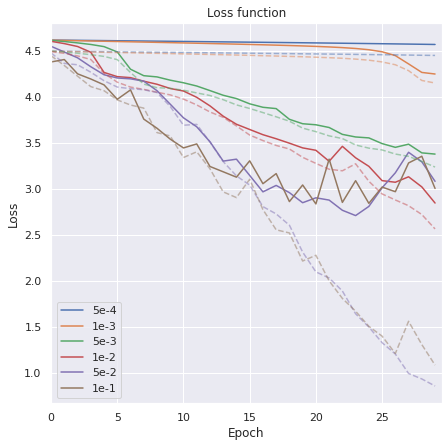

In [ ]:
results, files = file_res('3_1_1_')
lr_file = [f.split("3_1_1_")[1].split('.')[0] for f in files]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'--', 'val':'-'}
for phase in ['val', 'train']:
    for res in results.items():
        #print(res)
        epochs = len(res[1]["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        if phase == 'train':
            ax.plot(range(epochs), res[1][phase]["loss"], ls = ls[phase] , alpha=.5)
        else:
            ax.plot(range(epochs), res[1][phase]["loss"], ls = ls[phase])
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
    
ax.legend(lr_file)
print(results[0]['train']['acc'])

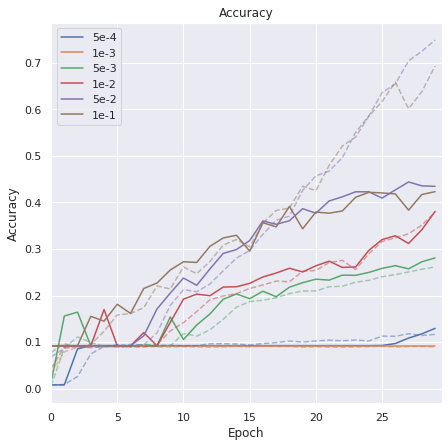

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'--', 'val':'-'}
for phase in ['val', 'train']:
    for res in results.items():
        #print(res[1]['train']['acc'])
        #print(res)
        epochs = len(res[1]["train"]["acc"])
        #plot loss 
        #ax.plot(range(epochs), res["train"]["loss"], marker='o')
        if phase == 'train':
            ax.plot(range(epochs), res[1][phase]["acc"], ls = ls[phase] , alpha=.5)
        else:
            ax.plot(range(epochs), res[1][phase]["acc"], ls = ls[phase])
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Accuracy")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
    
ax.legend(lr_file);


#### 3.2.2 SGD + NAG


In [ ]:
lr_list = [5e-3, 1e-2, 5e-2,]
lr_fnames = ["5e-3", "1e-2", "5e-2"]

MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

In [ ]:
for i, lr in enumerate(lr_list):
    print(f"SGD+NAG with learning rate: {lr}")
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, 
                          lr=lr, 
                          momentum=MOMENTUM, 
                          weight_decay=WEIGHT_DECAY,
                          nesterov=True)
    scheduler = None

    config = {'optimizer': optimizer, 
          'scheduler': scheduler, 
          'criterion': criterion, 
          'num_epochs': NUM_EPOCHS, 
          'device': 'cuda'}

    print(f"model {i} LR: {lr}")
    model, train_logs, val_logs = train_model(net,
                             dataloader,
                             config
                             )
    res = {'train': train_logs, 'val':val_logs}
    save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_1_2_{lr_fnames[i]}.csv"))
    models.append(model)
    results.append(res)
    t_acc = evaluate_test_set(model, test_dataloader)
    test_acc_list.append(t_acc)
    print(f"Test Accuracy: {t_acc}")
    print()
    print()


SGD+NAG with learning rate: 0.005
model 0 LR: 0.005
Epoch 1/30 
train	Loss:  4.4896	Acc:  0.0591
val	Loss:  4.6058	Acc:  0.0923
new best val loss  4.6058  (acc =  0.0923)

Epoch 2/30 
train	Loss:  4.4790	Acc:  0.0899
val	Loss:  4.5922	Acc:  0.0923
new best val loss  4.5922  (acc =  0.0923)

Epoch 3/30 
train	Loss:  4.4649	Acc:  0.0923
val	Loss:  4.5763	Acc:  0.0923
new best val loss  4.5763  (acc =  0.0923)

Epoch 4/30 
train	Loss:  4.4470	Acc:  0.1107
val	Loss:  4.5565	Acc:  0.1335
new best val loss  4.5565  (acc =  0.1335)

Epoch 5/30 
train	Loss:  4.4210	Acc:  0.1096
val	Loss:  4.5183	Acc:  0.0920
new best val loss  4.5183  (acc =  0.0920)

Epoch 6/30 
train	Loss:  4.3291	Acc:  0.0885
val	Loss:  4.2886	Acc:  0.0920
new best val loss  4.2886  (acc =  0.0920)

Epoch 7/30 
train	Loss:  4.1512	Acc:  0.0927
val	Loss:  4.2278	Acc:  0.0920
new best val loss  4.2278  (acc =  0.0920)

Epoch 8/30 
train	Loss:  4.1099	Acc:  0.0927
val	Loss:  4.2028	Acc:  0.0920
new best val loss  4.2028  (acc 

['3_1_2_5e-3.csv', '3_1_2_1e-2.csv', '3_1_2_5e-2.csv']


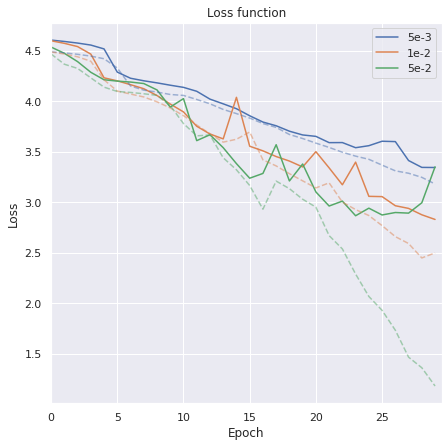

In [ ]:
results, files = file_res('3_1_2_')
lr_file = [f.split("3_1_2_")[1].split('.')[0] for f in files]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'--', 'val':'-'}
for phase in ['val', 'train']:
    for res in results.items():
        #print(res)
        epochs = len(res[1]["train"]["loss"])
        #plot loss 
        #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
        if phase == 'train':
            ax.plot(range(epochs), res[1][phase]["loss"], ls = ls[phase] , alpha=.5)
        else:
            ax.plot(range(epochs), res[1][phase]["loss"], ls = ls[phase])
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Loss function")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
    
ax.legend(lr_file)


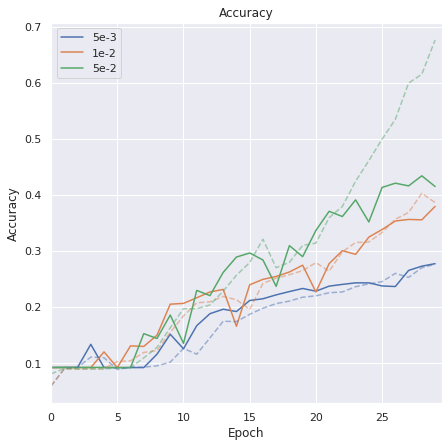

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ls = {'train':'--', 'val':'-'}
for phase in ['val', 'train']:
    for res in results.items():
        #print(res[1]['train']['acc'])
        #print(res)
        epochs = len(res[1]["train"]["acc"])
        #plot loss 
        #ax.plot(range(epochs), res["train"]["loss"], marker='o')
        if phase == 'train':
            ax.plot(range(epochs), res[1][phase]["acc"], ls = ls[phase] , alpha=.5)
        else:
            ax.plot(range(epochs), res[1][phase]["acc"], ls = ls[phase])
        #ax[0].set_ylim(0,5)
        ax.set_xlim(0, epochs-0.5)
        ax.set_title("Accuracy")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        #ax[0].set_xticks(range(0, epochs, 5))
    plt.gca().set_prop_cycle(None)
    
ax.legend(lr_file);


#### 3.2.3 Adam


In [ ]:
lr_list = [1e-4, 5e-4, 1e-3, 5e-3]
lr_fnames = ["1e-4", "5e-4", "1e-3", "5e-3"]

#MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

In [ ]:
for i, lr in enumerate(lr_list):
    print(f"Adam with learning rate: {lr}")
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.Adam(net.parameters(), 
                       lr= lr,
                       #amsgrad=True,
                       weight_decay=WEIGHT_DECAY)
    scheduler = None

    config = {'optimizer': optimizer, 
          'scheduler': scheduler, 
          'criterion': criterion, 
          'num_epochs': NUM_EPOCHS, 
          'device': 'cuda'}

    print(f"model {i} LR: {lr}")
    model, train_logs, val_logs = train_model(net,
                             dataloader,
                             config
                             )
    res = {'train': train_logs, 'val':val_logs}
    save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_1_3_{lr_fnames[i]}.csv"))
    models.append(model)
    results.append(res)
    t_acc = evaluate_test_set(model, test_dataloader)
    test_acc_list.append(t_acc)
    print(f"Test Accuracy: {t_acc}")
    print()
    print()


Adam with learning rate: 0.0001
model 0 LR: 0.0001
Epoch 1/30 
train	Loss:  4.2730	Acc:  0.0826
val	Loss:  4.2294	Acc:  0.0923
new best val loss  4.2294  (acc =  0.0923)

Epoch 2/30 
train	Loss:  4.0972	Acc:  0.0947
val	Loss:  4.1441	Acc:  0.1521
new best val loss  4.1441  (acc =  0.1521)

Epoch 3/30 
train	Loss:  3.9672	Acc:  0.1483
val	Loss:  3.9963	Acc:  0.2033
new best val loss  3.9963  (acc =  0.2033)

Epoch 4/30 
train	Loss:  3.7898	Acc:  0.1947
val	Loss:  3.8199	Acc:  0.2296
new best val loss  3.8199  (acc =  0.2296)

Epoch 5/30 
train	Loss:  3.5670	Acc:  0.2313
val	Loss:  3.5732	Acc:  0.2417
new best val loss  3.5732  (acc =  0.2417)

Epoch 6/30 
train	Loss:  3.3892	Acc:  0.2521
val	Loss:  3.4169	Acc:  0.2780
new best val loss  3.4169  (acc =  0.2780)

Epoch 7/30 
train	Loss:  3.1973	Acc:  0.2828
val	Loss:  3.2326	Acc:  0.2936
new best val loss  3.2326  (acc =  0.2936)

Epoch 8/30 
train	Loss:  3.0031	Acc:  0.3122
val	Loss:  3.1024	Acc:  0.3136
new best val loss  3.1024  (acc =

In [ ]:
def plot_res_from_file(starts_with, metric='loss', files=None):
    if files is None:
        results, files = file_res(starts_with)
        lr_file = [f.split(starts_with)[1].split('.')[0] for f in files]
    else:
        results, files = file_res(files=files)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ls = {'train':'--', 'val':'-'}
    for phase in ['val', 'train']:
        for res in results.items():
            #print(res)
            epochs = len(res[1]["train"][metric])
            #plot loss 
            #ax[0].plot(range(epochs), res["train"]["loss"], marker='o')
            if phase == 'train':
                ax.plot(range(epochs), res[1][phase][metric], ls = ls[phase] , alpha=.5)
            else:
                ax.plot(range(epochs), res[1][phase][metric], ls = ls[phase])
            #ax[0].set_ylim(0,5)
            ax.set_xlim(0, epochs-0.5)
            if metric == 'loss':
                ax.set_title("Loss function")
                ax.set_ylabel("Loss")
            else:
                ax.set_title("Accuracy")
                ax.set_ylabel("Accuracy")
            ax.set_xlabel("Epoch")
            #ax[0].set_xticks(range(0, epochs, 5))
        plt.gca().set_prop_cycle(None)
    if starts_with:
        ax.legend(lr_file)
    else:
        return ax


['3_1_3_1e-4.csv', '3_1_3_5e-4.csv', '3_1_3_1e-3.csv']


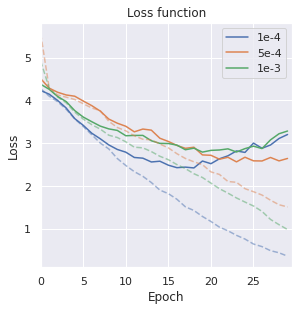

In [ ]:
plot_res_from_file('3_1_3_', 'loss')

['3_1_3_1e-4.csv', '3_1_3_5e-4.csv', '3_1_3_1e-3.csv']


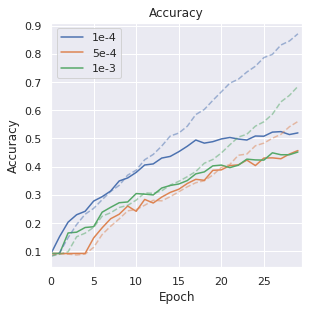

In [ ]:
plot_res_from_file('3_1_3_', 'acc')

#### 3.2.4 AdamW


In [ ]:
lr_list = [1e-4, 5e-4, 1e-3, 5e-3]
lr_fnames = ["1e-4", "5e-4", "1e-3", "5e-3"]

#MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

In [ ]:
for i, lr in enumerate(lr_list):
    print(f"AdamW with learning rate: {lr}")
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.AdamW(net.parameters(), 
                       lr= lr,
                       #amsgrad=True,
                       weight_decay=WEIGHT_DECAY)
    scheduler = None

    config = {'optimizer': optimizer, 
          'scheduler': scheduler, 
          'criterion': criterion, 
          'num_epochs': NUM_EPOCHS, 
          'device': 'cuda'}

    print(f"model {i} LR: {lr}")
    model, train_logs, val_logs = train_model(net,
                             dataloader,
                             config
                             )
    res = {'train': train_logs, 'val':val_logs}
    save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_1_4_{lr_fnames[i]}.csv"))
    models.append(model)
    results.append(res)
    t_acc = evaluate_test_set(model, test_dataloader)
    test_acc_list.append(t_acc)
    print(f"Test Accuracy: {t_acc}")
    print()
    print()


Adam with learning rate: 0.0001
model 0 LR: 0.0001
Epoch 1/30 
train	Loss:  4.3029	Acc:  0.0840
val	Loss:  4.2643	Acc:  0.0923
new best val loss  4.2643  (acc =  0.0923)

Epoch 2/30 
train	Loss:  4.1071	Acc:  0.0985
val	Loss:  4.1811	Acc:  0.0920
new best val loss  4.1811  (acc =  0.0920)

Epoch 3/30 
train	Loss:  4.0096	Acc:  0.1183
val	Loss:  4.0333	Acc:  0.1428
new best val loss  4.0333  (acc =  0.1428)

Epoch 4/30 
train	Loss:  3.8267	Acc:  0.1857
val	Loss:  3.7708	Acc:  0.2140
new best val loss  3.7708  (acc =  0.2140)

Epoch 5/30 
train	Loss:  3.5587	Acc:  0.2261
val	Loss:  3.5625	Acc:  0.2396
new best val loss  3.5625  (acc =  0.2396)

Epoch 6/30 
train	Loss:  3.3638	Acc:  0.2507
val	Loss:  3.3805	Acc:  0.2752
new best val loss  3.3805  (acc =  0.2752)

Epoch 7/30 
train	Loss:  3.1932	Acc:  0.2822
val	Loss:  3.2636	Acc:  0.2939
new best val loss  3.2636  (acc =  0.2939)

Epoch 8/30 
train	Loss:  3.0097	Acc:  0.3043
val	Loss:  3.2524	Acc:  0.3084
new best val loss  3.2524  (acc =

['3_1_4_1e-4.csv', '3_1_4_5e-4.csv', '3_1_4_1e-3.csv']


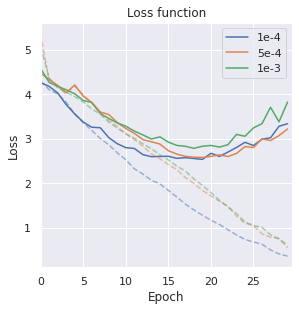

In [ ]:
plot_res_from_file('3_1_4_', 'loss')

['3_1_3_1e-4.csv', '3_1_3_5e-4.csv', '3_1_3_1e-3.csv']


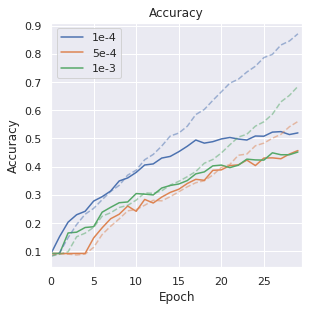

In [ ]:
plot_res_from_file('3_1_3_', 'acc')

### 3.3 Different WDs

#### 3.3.1 SGD 

In [ ]:
lr_list = [1e-2, 5e-2]
lr_fnames = ["1e-2", "5e-2" ]

MOMENTUM = 0.9
wd_list = [5e-1, 5e-3, 5e-5]
wd_fnames = ["5e-1", "5e-3", "5e-5"]
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

In [ ]:
for NAG in [True, False]:
    for i, lr in enumerate(lr_list):
        for wd, wdf in zip(wd_list, wd_fnames):
            print(f"SGD with learning rate: {lr} weight decay: {wd}")
            net = alexnet() # Loading AlexNet model
            net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

            # Define loss function
            criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
            parameters_to_optimize = net.parameters() 
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=lr, 
                                momentum=MOMENTUM, 
                                weight_decay=wd,
                                nesterov = NAG)
            scheduler = None

            config = {'optimizer': optimizer, 
                'scheduler': scheduler, 
                'criterion': criterion, 
                'num_epochs': NUM_EPOCHS, 
                'device': 'cuda'}

            print(f"model {i} LR: {lr}")
            model, train_logs, val_logs = train_model(net,
                                    dataloader,
                                    config
                                    )
            res = {'train': train_logs, 'val':val_logs}
            if NAG:
                name = "3_2_1_NAG_"
            else:
                name = "3_2_1_"
            save_results(res, os.path.join('./drive/MyDrive/HW2/', f"{name}{lr_fnames[i]}_{wdf}.csv"))

            models.append(model)
            results.append(res)
            t_acc = evaluate_test_set(model, test_dataloader)
            test_acc_list.append(t_acc)
            print(f"Test Accuracy: {t_acc}")
            print()
            print()


SGD with learning rate: 0.01 weight decay: 0.5
model 0 LR: 0.01
Epoch 1/30 
train	Loss:  4.4900	Acc:  0.0550
val	Loss:  4.6038	Acc:  0.0923
new best val loss  4.6038  (acc =  0.0923)

Epoch 2/30 
train	Loss:  4.4769	Acc:  0.0896
val	Loss:  4.5914	Acc:  0.0923
new best val loss  4.5914  (acc =  0.0923)

Epoch 3/30 
train	Loss:  4.4670	Acc:  0.0906
val	Loss:  4.5837	Acc:  0.0923
new best val loss  4.5837  (acc =  0.0923)

Epoch 4/30 
train	Loss:  4.4614	Acc:  0.0844
val	Loss:  4.5797	Acc:  0.0920
new best val loss  4.5797  (acc =  0.0920)

Epoch 5/30 
train	Loss:  4.4585	Acc:  0.0899
val	Loss:  4.5782	Acc:  0.0920
new best val loss  4.5782  (acc =  0.0920)

Epoch 6/30 
train	Loss:  4.4575	Acc:  0.0902
val	Loss:  4.5781	Acc:  0.0923
new best val loss  4.5781  (acc =  0.0923)

Epoch 7/30 
train	Loss:  4.4576	Acc:  0.0896
val	Loss:  4.5781	Acc:  0.0923

Epoch 8/30 
train	Loss:  4.4580	Acc:  0.0816
val	Loss:  4.5786	Acc:  0.0920

Epoch 9/30 
train	Loss:  4.4582	Acc:  0.0854
val	Loss:  4.5787

#### 3.3.2 Adam

In [ ]:
lr = 1e-4
lr_fname= "1e-4"

wd_list = [5e-1, 5e-3, 5e-5]
wd_fnames = ["5e-1", "5e-3", "5e-5"]

NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

In [ ]:
for wd, wdf in zip(wd_list, wd_fnames):
    print(f"Adam with learning rate: {lr} weight_decay: {wd}")
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.Adam(net.parameters(), 
                       lr= lr,
                       #amsgrad=True,
                       weight_decay=wd)
    scheduler = None

    config = {'optimizer': optimizer, 
          'scheduler': scheduler, 
          'criterion': criterion, 
          'num_epochs': NUM_EPOCHS, 
          'device': 'cuda'}

    print(f"model {i} LR: {lr}")
    model, train_logs, val_logs = train_model(net,
                             dataloader,
                             config
                             )
    res = {'train': train_logs, 'val':val_logs}
    save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_2_2_{wdf}.csv"))
    models.append(model)
    results.append(res)
    t_acc = evaluate_test_set(model, test_dataloader)
    test_acc_list.append(t_acc)
    print(f"Test Accuracy: {t_acc}")
    print()
    print()


Adam with learning rate: 0.0001 weight_decay: 0.5
model 1 LR: 0.0001
Epoch 1/30 
train	Loss:  4.4934	Acc:  0.0045
val	Loss:  4.6140	Acc:  0.0048
new best val loss  4.6140  (acc =  0.0048)

Epoch 2/30 
train	Loss:  4.4923	Acc:  0.0048
val	Loss:  4.6132	Acc:  0.0048
new best val loss  4.6132  (acc =  0.0048)

Epoch 3/30 
train	Loss:  4.4917	Acc:  0.0256
val	Loss:  4.6126	Acc:  0.0920
new best val loss  4.6126  (acc =  0.0920)

Epoch 4/30 
train	Loss:  4.4911	Acc:  0.0902
val	Loss:  4.6120	Acc:  0.0920
new best val loss  4.6120  (acc =  0.0920)

Epoch 5/30 
train	Loss:  4.4907	Acc:  0.0906
val	Loss:  4.6116	Acc:  0.0920
new best val loss  4.6116  (acc =  0.0920)

Epoch 6/30 
train	Loss:  4.4903	Acc:  0.0896
val	Loss:  4.6112	Acc:  0.0920
new best val loss  4.6112  (acc =  0.0920)

Epoch 7/30 
train	Loss:  4.4900	Acc:  0.0882
val	Loss:  4.6109	Acc:  0.0920
new best val loss  4.6109  (acc =  0.0920)

Epoch 8/30 
train	Loss:  4.4897	Acc:  0.0885
val	Loss:  4.6106	Acc:  0.0920
new best val lo

#### 3.3.3 AdamW

In [ ]:
lr = 1e-4
lr_fname= "1e-4"

wd_list = [5e-1, 5e-3, 5e-5]
wd_fnames = ["5e-1", "5e-3", "5e-5"]

NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

In [ ]:
for wd, wdf in zip(wd_list, wd_fnames):
    print(f"Adam with learning rate: {lr} weight_decay: {wd}")
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.AdamW(net.parameters(), 
                       lr= lr,
                       #amsgrad=True,
                       weight_decay=wd)
    scheduler = None

    config = {'optimizer': optimizer, 
          'scheduler': scheduler, 
          'criterion': criterion, 
          'num_epochs': NUM_EPOCHS, 
          'device': 'cuda'}

    print(f"model {i} LR: {lr}")
    model, train_logs, val_logs = train_model(net,
                             dataloader,
                             config
                             )
    res = {'train': train_logs, 'val':val_logs}
    save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_2_3_{wdf}.csv"))
    models.append(model)
    results.append(res)
    t_acc = evaluate_test_set(model, test_dataloader)
    test_acc_list.append(t_acc)
    print(f"Test Accuracy: {t_acc}")
    print()
    print()


Adam with learning rate: 0.0001 weight_decay: 0.5
model 1 LR: 0.0001
Epoch 1/30 
train	Loss:  4.2851	Acc:  0.0861
val	Loss:  4.2252	Acc:  0.0920
new best val loss  4.2252  (acc =  0.0920)

Epoch 2/30 
train	Loss:  4.0911	Acc:  0.1051
val	Loss:  4.1439	Acc:  0.1113
new best val loss  4.1439  (acc =  0.1113)

Epoch 3/30 
train	Loss:  3.9984	Acc:  0.1234
val	Loss:  4.0241	Acc:  0.1276
new best val loss  4.0241  (acc =  0.1276)

Epoch 4/30 
train	Loss:  3.7999	Acc:  0.1826
val	Loss:  3.7440	Acc:  0.2172
new best val loss  3.7440  (acc =  0.2172)

Epoch 5/30 
train	Loss:  3.5247	Acc:  0.2296
val	Loss:  3.5372	Acc:  0.2389
new best val loss  3.5372  (acc =  0.2389)

Epoch 6/30 
train	Loss:  3.3860	Acc:  0.2490
val	Loss:  3.4120	Acc:  0.2739
new best val loss  3.4120  (acc =  0.2739)

Epoch 7/30 
train	Loss:  3.2082	Acc:  0.2749
val	Loss:  3.2682	Acc:  0.2939
new best val loss  3.2682  (acc =  0.2939)

Epoch 8/30 
train	Loss:  3.0305	Acc:  0.3005
val	Loss:  3.1095	Acc:  0.3185
new best val lo

### 3.4 Different LR scheduler configurations

#### 3.4.1 SGD

In [ ]:
scheduler_list = [(1, 0.5), (1, 0.9), 
                  (10, 0.1), (10, 0.5), 
                  (15, 0.1), (15, 0.5), (15, 0.7)]
lr_list = [5e-2]
lr_fnames = ["5e-2" ]

MOMENTUM = 0.9
wd = 5e-5
wd_fnames = ["5e-5"]
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []


In [ ]:
for i, lr in enumerate(lr_list):
    for step_size, gamma in scheduler_list:
        print(f"SGD with learning rate: {lr} weight decay: {wd}")
        print(f"Step size: {step_size} Gamma: {gamma}")
        net = alexnet() # Loading AlexNet model
        net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

        # Define loss function
        criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
        parameters_to_optimize = net.parameters() 
        optimizer = optim.SGD(parameters_to_optimize, 
                            lr=lr, 
                            momentum=MOMENTUM, 
                            weight_decay=wd,
                            nesterov = False)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        config = {'optimizer': optimizer, 
            'scheduler': scheduler, 
            'criterion': criterion, 
            'num_epochs': NUM_EPOCHS, 
            'device': 'cuda'}

        print(f"model {i} LR: {lr}")
        model, train_logs, val_logs = train_model(net,
                                dataloader,
                                config
                                )
        res = {'train': train_logs, 'val':val_logs}
        save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_3_1_{lr_fnames[i]}_{wdf}_{step_size}_{gamma}.csv"))

        models.append(model)
        results.append(res)
        t_acc = evaluate_test_set(model, test_dataloader)
        test_acc_list.append(t_acc)
        print(f"Test Accuracy: {t_acc}")
        print()
        print()


SGD with learning rate: 0.05 weight decay: 5e-05
Step size: 1 Gamma: 0.5
model 0 LR: 0.05
Epoch 1/30 lr : [0.05]
train	Loss:  4.4726	Acc:  0.0764
val	Loss:  4.5482	Acc:  0.0923
new best val loss  4.5482  (acc =  0.0923)

Epoch 2/30 lr : [0.025]
train	Loss:  4.3689	Acc:  0.1048
val	Loss:  4.2624	Acc:  0.0920
new best val loss  4.2624  (acc =  0.0920)

Epoch 3/30 lr : [0.0125]
train	Loss:  4.1704	Acc:  0.0989
val	Loss:  4.2099	Acc:  0.1608
new best val loss  4.2099  (acc =  0.1608)

Epoch 4/30 lr : [0.00625]
train	Loss:  4.1007	Acc:  0.1010
val	Loss:  4.1882	Acc:  0.0920
new best val loss  4.1882  (acc =  0.0920)

Epoch 5/30 lr : [0.003125]
train	Loss:  4.0820	Acc:  0.0913
val	Loss:  4.1986	Acc:  0.0930

Epoch 6/30 lr : [0.0015625]
train	Loss:  4.0802	Acc:  0.0972
val	Loss:  4.1742	Acc:  0.0985
new best val loss  4.1742  (acc =  0.0985)

Epoch 7/30 lr : [0.00078125]
train	Loss:  4.0685	Acc:  0.0985
val	Loss:  4.1714	Acc:  0.1048
new best val loss  4.1714  (acc =  0.1048)

Epoch 8/30 lr :

#### 3.4.2 AdamW

In [ ]:
lr = 1e-4
lr_fname= "1e-4"

wd = 5e-3
#wd_fnames = ["5e-1", "5e-3", "5e-5"]

NUM_EPOCHS = 30

scheduler_list = [(1, 0.5), (1, 0.9), 
                  (10, 0.1), (10, 0.5), 
                  (15, 0.1), (15, 0.5), (15, 0.7)]

results = []
models = []

test_acc_list = []

In [ ]:
for step_size, gamma in scheduler_list:    
    print(f"Adam with learning rate: {lr} weight_decay: {wd}")
    print(f"Step size: {step_size} Gamma: {gamma}")
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.AdamW(net.parameters(), 
                       lr= lr,
                       #amsgrad=True,
                       weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    config = {'optimizer': optimizer, 
          'scheduler': scheduler, 
          'criterion': criterion, 
          'num_epochs': NUM_EPOCHS, 
          'device': 'cuda'}

    print(f"model {i} LR: {lr}")
    model, train_logs, val_logs = train_model(net,
                             dataloader,
                             config
                             )
    res = {'train': train_logs, 'val':val_logs}
    save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_3_2_{lr_fname}_{step_size}_{gamma}.csv"))
    models.append(model)
    results.append(res)
    t_acc = evaluate_test_set(model, test_dataloader)
    test_acc_list.append(t_acc)
    print(f"Test Accuracy: {t_acc}")
    print()
    print()


Adam with learning rate: 0.0001 weight_decay: 0.005
Step size: 1 Gamma: 0.5
model 0 LR: 0.0001
Epoch 1/30 lr : [0.0001]
train	Loss:  4.3278	Acc:  0.0775
val	Loss:  4.3123	Acc:  0.0923
new best val loss  4.3123  (acc =  0.0923)

Epoch 2/30 lr : [5e-05]
train	Loss:  4.1467	Acc:  0.0906
val	Loss:  4.2010	Acc:  0.0920
new best val loss  4.2010  (acc =  0.0920)

Epoch 3/30 lr : [2.5e-05]
train	Loss:  4.0928	Acc:  0.0892
val	Loss:  4.1826	Acc:  0.0920
new best val loss  4.1826  (acc =  0.0920)

Epoch 4/30 lr : [1.25e-05]
train	Loss:  4.0668	Acc:  0.0913
val	Loss:  4.1665	Acc:  0.1079
new best val loss  4.1665  (acc =  0.1079)

Epoch 5/30 lr : [6.25e-06]
train	Loss:  4.0533	Acc:  0.1165
val	Loss:  4.1568	Acc:  0.1380
new best val loss  4.1568  (acc =  0.1380)

Epoch 6/30 lr : [3.125e-06]
train	Loss:  4.0490	Acc:  0.1290
val	Loss:  4.1521	Acc:  0.1414
new best val loss  4.1521  (acc =  0.1414)

Epoch 7/30 lr : [1.5625e-06]
train	Loss:  4.0460	Acc:  0.1328
val	Loss:  4.1488	Acc:  0.1449
new bes

### 3.5 Different Batch Sizes

#### 3.5.1 AdamW

In [ ]:
batch_sizes = [32, 64, 128, 512]

lr = 1e-4
lr_fnames = ["1e-4" ]

wd = 5e-3
wd_fnames = ["5e-3"]
NUM_EPOCHS = 30

step_size = 15
gamma = 0.5

results = []
models = []

test_acc_list = []

In [ ]:
for batch_size in batch_sizes:
    # Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    #test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    dataloader = {'train': train_dataloader, 'val': val_dataloader}
    dataset = {'train': train_dataset, 'val': val_dataset}
    
    print(f"AdamW with learning rate: {lr} weight decay: {wd}")
    print(f"Step size: {step_size} Gamma: {gamma}")
    net = alexnet() # Loading AlexNet model
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
    parameters_to_optimize = net.parameters() 
    optimizer = optim.AdamW(net.parameters(), 
                       lr= lr,
                       #amsgrad=True,
                       weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    config = {'optimizer': optimizer, 
        'scheduler': scheduler, 
        'criterion': criterion, 
        'num_epochs': NUM_EPOCHS, 
        'device': 'cuda'}

    model, train_logs, val_logs = train_model(net,
                            dataloader,
                            config
                            )
    res = {'train': train_logs, 'val':val_logs}
    save_results(res, os.path.join('./drive/MyDrive/HW2/', f"3_4_adamw_{batch_size}.csv"))

    models.append(model)
    results.append(res)
    t_acc = evaluate_test_set(model, test_dataloader)
    test_acc_list.append(t_acc)
    print(f"Test Accuracy: {t_acc}")
    print()
    print()




AdamW with learning rate: 0.0001 weight decay: 0.005
Step size: 15 Gamma: 0.5
Epoch 1/30 lr : [0.0001]
train	Loss:  4.2219	Acc:  0.1252
val	Loss:  3.8563	Acc:  0.1995
new best val loss  3.8563  (acc =  0.1995)

Epoch 2/30 lr : [0.0001]
train	Loss:  3.5948	Acc:  0.2327
val	Loss:  3.3705	Acc:  0.2742
new best val loss  3.3705  (acc =  0.2742)

Epoch 3/30 lr : [0.0001]
train	Loss:  3.2322	Acc:  0.2984
val	Loss:  3.1484	Acc:  0.3122
new best val loss  3.1484  (acc =  0.3122)

Epoch 4/30 lr : [0.0001]
train	Loss:  2.9277	Acc:  0.3375
val	Loss:  2.8660	Acc:  0.3589
new best val loss  2.8660  (acc =  0.3589)

Epoch 5/30 lr : [0.0001]
train	Loss:  2.6325	Acc:  0.3859
val	Loss:  2.6711	Acc:  0.4035
new best val loss  2.6711  (acc =  0.4035)

Epoch 6/30 lr : [0.0001]
train	Loss:  2.3595	Acc:  0.4385
val	Loss:  2.5638	Acc:  0.4236
new best val loss  2.5638  (acc =  0.4236)

Epoch 7/30 lr : [0.0001]
train	Loss:  2.0664	Acc:  0.4976
val	Loss:  2.4255	Acc:  0.4519
new best val loss  2.4255  (acc =  

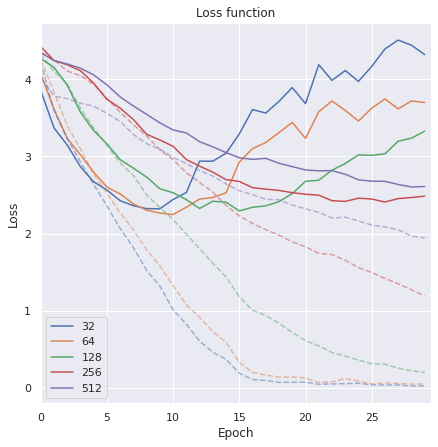

In [ ]:
ax = plot_res_from_file(None, 'loss', ['3_4_adamw_32.csv', 
                                  '3_4_adamw_64.csv', 
                                  '3_4_adamw_128.csv', 
                                  '3_3_2_1e-4_15_0.5.csv', 
                                  '3_4_adamw_512.csv'])
ax.legend([32, 64, 128, 256, 512])

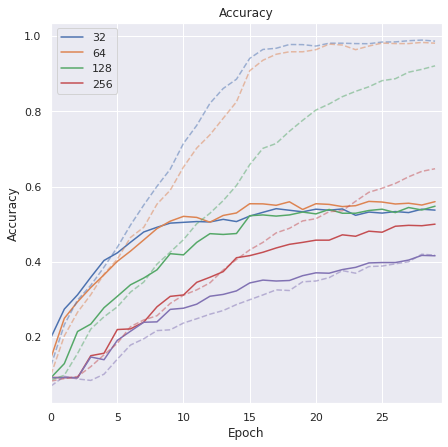

In [ ]:
ax = plot_res_from_file(None, 'acc', ['3_4_adamw_32.csv', 
                                  '3_4_adamw_64.csv', 
                                  '3_4_adamw_128.csv', 
                                  '3_3_2_1e-4_15_0.5.csv', 
                                  '3_4_adamw_512.csv'])
ax.legend([32, 64, 128, 256])

## 4. Transfer Learning

In [ ]:
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(norm_imagenet_mean, norm_imagenet_std) # Normalizes tensor with mean and standard deviation
])
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)                                    
])

train_dataset.transform = train_transform
val_dataset.transform = eval_transform
test_dataset.transform = eval_transform
print(dataloader['train'].dataset.transform)
print(dataloader['val'].dataset.transform)
print(test_dataloader.dataset.transform)



Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


### 4.1 Fine Tuning

#### 4.1.1 SGD

In [ ]:
lr_list = [1e-3, 5e-3, 1e-2]
lr_fnames = ["1e-3", "5e-3", "1e-2"]

gamma = 0.5
step_size = 15

MOMENTUM = 0.9
wd_list = [5e-3, 5e-4, 5e-5]
wd_fnames = ["5e-3", "5e-4", "5e-5"]
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

In [ ]:
for NAG in [True, False]:
    for i, lr in enumerate(lr_list):
        for wd, wdf in zip(wd_list, wd_fnames):
            if NAG:
                print(f"NAG with lr: {lr} wd:{wd}")
            else:
                print(f"SGD with lr: {lr} wd:{wd}")
            net = alexnet(pretrained=True) # Loading AlexNet model
            net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

            # Define loss function
            criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
            parameters_to_optimize = net.parameters() 
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=lr, 
                                momentum=MOMENTUM, 
                                weight_decay=WEIGHT_DECAY,
                                nesterov = NAG)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

            config = {'optimizer': optimizer, 
                'scheduler': scheduler, 
                'criterion': criterion, 
                'num_epochs': NUM_EPOCHS, 
                'device': 'cuda'}

            print(f"model {i} LR: {lr}")
            model, train_logs, val_logs = train_model(net,
                                    dataloader,
                                    config
                                    )
            res = {'train': train_logs, 'val':val_logs}
            if NAG:
                name = "4_1_1_NAG_"
            else:
                name = "4_1_1_"
            save_results(res, os.path.join('./drive/MyDrive/HW2/', f"{name}{lr_fnames[i]}_{wdf}.csv"))
            models.append(model)
            results.append(res)
            t_acc = evaluate_test_set(model, test_dataloader)
            test_acc_list.append(t_acc)
            print(f"Test Accuracy: {t_acc}")
            print()
            print()


NAG with lr: 0.001 wd:0.005


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



model 0 LR: 0.001
Epoch 1/30 lr : [0.001]
train	Loss:  3.8791	Acc:  0.1708
val	Loss:  3.1713	Acc:  0.3039
new best val loss  3.1713  (acc =  0.3039)

Epoch 2/30 lr : [0.001]
train	Loss:  2.6720	Acc:  0.3900
val	Loss:  2.3664	Acc:  0.4910
new best val loss  2.3664  (acc =  0.4910)

Epoch 3/30 lr : [0.001]
train	Loss:  1.8542	Acc:  0.5557
val	Loss:  1.6274	Acc:  0.6238
new best val loss  1.6274  (acc =  0.6238)

Epoch 4/30 lr : [0.001]
train	Loss:  1.1132	Acc:  0.6999
val	Loss:  1.1114	Acc:  0.7168
new best val loss  1.1114  (acc =  0.7168)

Epoch 5/30 lr : [0.001]
train	Loss:  0.6682	Acc:  0.7988
val	Loss:  0.8827	Acc:  0.7649
new best val loss  0.8827  (acc =  0.7649)

Epoch 6/30 lr : [0.001]
train	Loss:  0.4331	Acc:  0.8510
val	Loss:  0.8043	Acc:  0.7835
new best val loss  0.8043  (acc =  0.7835)

Epoch 7/30 lr : [0.001]
train	Loss:  0.3104	Acc:  0.8945
val	Loss:  0.7690	Acc:  0.7925
new best val loss  0.7690  (acc =  0.7925)

Epoch 8/30 lr : [0.001]
train	Loss:  0.2081	Acc:  0.9184


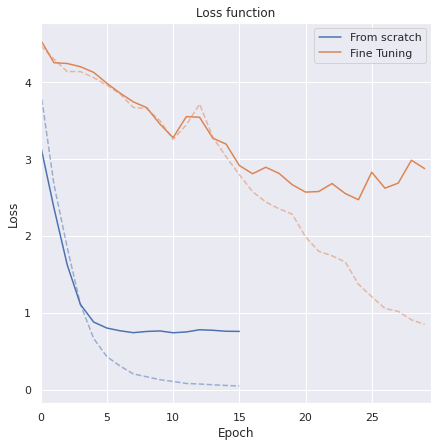

In [ ]:
ax = plot_res_from_file(None, metric='loss', files=['4_1_1_NAG_1e-3_5e-3.csv', '3_3_1_5e-2_5e-5_15_0.5.csv'])
ax.legend(['From scratch', 'Fine Tuning'])

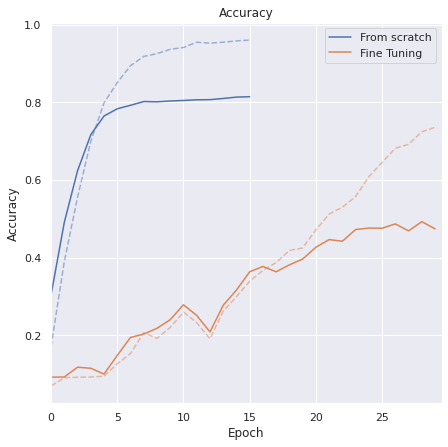

In [ ]:
ax = plot_res_from_file(None, metric='acc', files=['4_1_1_NAG_1e-3_5e-3.csv', '3_3_1_5e-2_5e-5_15_0.5.csv'])
ax.legend(['From scratch', 'Fine Tuning'])

#### 4.1.2 AdamW

In [ ]:
lr_list = [1e-5, 5e-5, 1e-4, 5e-4]
lr_fnames = ["1e-5", "5e-5", "1e-4", "5e-4"]

gamma = 0.5
step_size = 15

MOMENTUM = 0.9
wd_list = [5e-3, 5e-4, 5e-5]
wd_fnames = ["5e-3", "5e-4", "5e-5"]
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

In [ ]:
for lr, lrf in zip(lr_list, lr_fnames):
    for wd, wdf in zip(wd_list, wd_fnames):
        print(f"AdamW with learning rate: {lr} weight_decay: {wd}")
        net = alexnet(pretrained=True) # Loading AlexNet model
        net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

        # Define loss function
        criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
        parameters_to_optimize = net.parameters() 
        optimizer = optim.AdamW(net.parameters(), 
                        lr= lr,
                        #amsgrad=True,
                        weight_decay=wd)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


        config = {'optimizer': optimizer, 
            'scheduler': scheduler, 
            'criterion': criterion, 
            'num_epochs': NUM_EPOCHS, 
            'device': 'cuda'}

        print(f"model {i} LR: {lr}")
        model, train_logs, val_logs = train_model(net,
                                dataloader,
                                config
                                )
        res = {'train': train_logs, 'val':val_logs}
        save_results(res, os.path.join('./drive/MyDrive/HW2/', f"4_1_2_{lrf}_{wdf}.csv"))
        models.append(model)
        results.append(res)
        t_acc = evaluate_test_set(model, test_dataloader)
        test_acc_list.append(t_acc)
        print(f"Test Accuracy: {t_acc}")
        print()
        print()


AdamW with learning rate: 1e-05 weight_decay: 0.005
model 2 LR: 1e-05
Epoch 1/30 lr : [1e-05]
train	Loss:  4.3985	Acc:  0.0892
val	Loss:  4.1402	Acc:  0.1840
new best val loss  4.1402  (acc =  0.1840)

Epoch 2/30 lr : [1e-05]
train	Loss:  3.8550	Acc:  0.1971
val	Loss:  3.6861	Acc:  0.2472
new best val loss  3.6861  (acc =  0.2472)

Epoch 3/30 lr : [1e-05]
train	Loss:  3.4315	Acc:  0.2559
val	Loss:  3.3462	Acc:  0.2867
new best val loss  3.3462  (acc =  0.2867)

Epoch 4/30 lr : [1e-05]
train	Loss:  3.0777	Acc:  0.2998
val	Loss:  3.0098	Acc:  0.3288
new best val loss  3.0098  (acc =  0.3288)

Epoch 5/30 lr : [1e-05]
train	Loss:  2.7417	Acc:  0.3579
val	Loss:  2.7161	Acc:  0.4122
new best val loss  2.7161  (acc =  0.4122)

Epoch 6/30 lr : [1e-05]
train	Loss:  2.4466	Acc:  0.4236
val	Loss:  2.4449	Acc:  0.4744
new best val loss  2.4449  (acc =  0.4744)

Epoch 7/30 lr : [1e-05]
train	Loss:  2.1142	Acc:  0.4931
val	Loss:  2.1824	Acc:  0.5156
new best val loss  2.1824  (acc =  0.5156)

Epoch 

### 4.2 Frozen CONV layers - Tune FC layers

#### 4.2.1 SGD

In [ ]:
lr_list = [1e-3, 5e-3, 1e-2, 5e-2]
lr_fnames = ["1e-3", "5e-3", "1e-2", "5e-2"]

gamma = 0.5
step_size = 15

MOMENTUM = 0.9
wd_list = [5e-3, 5e-4, 5e-5]
wd_fnames = ["5e-3", "5e-4", "5e-5"]
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []
for NAG in [True, False]:
    for i, lr in enumerate(lr_list):
        for wd, wdf in zip(wd_list, wd_fnames):
            if NAG:
                print(f"NAG with lr: {lr} wd:{wd}")
            else:
                print(f"SGD with lr: {lr} wd:{wd}")
            net = alexnet(pretrained=True) # Loading AlexNet model
            for param in net.parameters():
                param.requires_grad = False
            for param in net.classifier.parameters():
                param.requires_grad = True
            net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

            # Define loss function
            criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
            parameters_to_optimize = net.parameters() 
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=lr, 
                                momentum=MOMENTUM, 
                                weight_decay=WEIGHT_DECAY,
                                nesterov = NAG)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

            config = {'optimizer': optimizer, 
                'scheduler': scheduler, 
                'criterion': criterion, 
                'num_epochs': NUM_EPOCHS, 
                'device': 'cuda'}

            print(f"model {i} LR: {lr}")
            model, train_logs, val_logs = train_model(net,
                                    dataloader,
                                    config
                                    )
            res = {'train': train_logs, 'val':val_logs}
            if NAG:
                name = "4_2_1_NAG_"
            else:
                name = "4_2_1_"
            save_results(res, os.path.join('./drive/MyDrive/HW2/', f"{name}{lr_fnames[i]}_{wdf}.csv"))
            models.append(model)
            results.append(res)
            t_acc = evaluate_test_set(model, test_dataloader)
            test_acc_list.append(t_acc)
            print(f"Test Accuracy: {t_acc}")
            print()
            print()


NAG with lr: 0.001 wd:0.005
model 0 LR: 0.001
Epoch 1/30 lr : [0.001]
train	Loss:  3.8830	Acc:  0.1805
val	Loss:  3.1409	Acc:  0.3067
new best val loss  3.1409  (acc =  0.3067)

Epoch 2/30 lr : [0.001]
train	Loss:  2.6678	Acc:  0.3762
val	Loss:  2.3579	Acc:  0.4934
new best val loss  2.3579  (acc =  0.4934)

Epoch 3/30 lr : [0.001]
train	Loss:  1.9568	Acc:  0.5491
val	Loss:  1.8683	Acc:  0.6100
new best val loss  1.8683  (acc =  0.6100)

Epoch 4/30 lr : [0.001]
train	Loss:  1.5080	Acc:  0.6660
val	Loss:  1.5355	Acc:  0.6891
new best val loss  1.5355  (acc =  0.6891)

Epoch 5/30 lr : [0.001]
train	Loss:  1.1908	Acc:  0.7414
val	Loss:  1.3003	Acc:  0.7382
new best val loss  1.3003  (acc =  0.7382)

Epoch 6/30 lr : [0.001]
train	Loss:  0.9503	Acc:  0.7956
val	Loss:  1.1346	Acc:  0.7663
new best val loss  1.1346  (acc =  0.7663)

Epoch 7/30 lr : [0.001]
train	Loss:  0.7843	Acc:  0.8299
val	Loss:  1.0120	Acc:  0.7877
new best val loss  1.0120  (acc =  0.7877)

Epoch 8/30 lr : [0.001]
train	

#### 4.2.2 AdamW

In [ ]:
lr_list = [1e-5, 5e-5, 1e-4, 5e-4]
lr_fnames = ["1e-5", "5e-5", "1e-4", "5e-4"]

gamma = 0.5
step_size = 15

MOMENTUM = 0.9
wd_list = [5e-3, 5e-4, 5e-5]
wd_fnames = ["5e-3", "5e-4", "5e-5"]
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

for lr, lrf in zip(lr_list, lr_fnames):
    for wd, wdf in zip(wd_list, wd_fnames):
        print(f"AdamW with learning rate: {lr} weight_decay: {wd}")
        net = alexnet(pretrained=True) # Loading AlexNet model
        for param in net.parameters():
            param.requires_grad = False
        for param in net.classifier.parameters():
            param.requires_grad = True
        net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

        # Define loss function
        criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
        parameters_to_optimize = net.parameters() 
        optimizer = optim.AdamW(net.parameters(), 
                        lr= lr,
                        #amsgrad=True,
                        weight_decay=wd)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


        config = {'optimizer': optimizer, 
            'scheduler': scheduler, 
            'criterion': criterion, 
            'num_epochs': NUM_EPOCHS, 
            'device': 'cuda'}

        print(f"model {i} LR: {lr}")
        model, train_logs, val_logs = train_model(net,
                                dataloader,
                                config
                                )
        res = {'train': train_logs, 'val':val_logs}
        save_results(res, os.path.join('./drive/MyDrive/HW2/', f"4_2_2_{lrf}_{wdf}.csv"))
        models.append(model)
        results.append(res)
        t_acc = evaluate_test_set(model, test_dataloader)
        test_acc_list.append(t_acc)
        print(f"Test Accuracy: {t_acc}")
        print()
        print()


AdamW with learning rate: 1e-05 weight_decay: 0.005
model 3 LR: 1e-05
Epoch 1/30 lr : [1e-05]
train	Loss:  4.5885	Acc:  0.0252
val	Loss:  4.3698	Acc:  0.0944
new best val loss  4.3698  (acc =  0.0944)

Epoch 2/30 lr : [1e-05]
train	Loss:  4.0777	Acc:  0.1490
val	Loss:  3.9336	Acc:  0.2538
new best val loss  3.9336  (acc =  0.2538)

Epoch 3/30 lr : [1e-05]
train	Loss:  3.6388	Acc:  0.2676
val	Loss:  3.5356	Acc:  0.3057
new best val loss  3.5356  (acc =  0.3057)

Epoch 4/30 lr : [1e-05]
train	Loss:  3.2474	Acc:  0.3091
val	Loss:  3.2231	Acc:  0.3347
new best val loss  3.2231  (acc =  0.3347)

Epoch 5/30 lr : [1e-05]
train	Loss:  2.9465	Acc:  0.3482
val	Loss:  2.9666	Acc:  0.3748
new best val loss  2.9666  (acc =  0.3748)

Epoch 6/30 lr : [1e-05]
train	Loss:  2.7000	Acc:  0.3817
val	Loss:  2.7407	Acc:  0.4205
new best val loss  2.7407  (acc =  0.4205)

Epoch 7/30 lr : [1e-05]
train	Loss:  2.4618	Acc:  0.4474
val	Loss:  2.5376	Acc:  0.4716
new best val loss  2.5376  (acc =  0.4716)

Epoch 

### 4.3 Tune CONV layers - Frozen FC layers

#### 4.3.1 SGD

In [ ]:
lr_list = [1e-3, 5e-3, 1e-2]
lr_fnames = ["1e-3", "5e-3", "1e-2"]

gamma = 0.5
step_size = 15

MOMENTUM = 0.9
wd_list = [5e-3, 5e-4, 5e-5]
wd_fnames = ["5e-3", "5e-4", "5e-5"]
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []
for NAG in [True, False]:
    for i, lr in enumerate(lr_list):
        for wd, wdf in zip(wd_list, wd_fnames):
            if NAG:
                print(f"NAG with lr: {lr} wd:{wd}")
            else:
                print(f"SGD with lr: {lr} wd:{wd}")
            net = alexnet(pretrained=True) # Loading AlexNet model
            for param in net.classifier.parameters():
                param.requires_grad = False
            net.classifier[6] = nn.Linear(4096, 101) 

            # Define loss function
            criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
            parameters_to_optimize = net.parameters() 
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=lr, 
                                momentum=MOMENTUM, 
                                weight_decay=WEIGHT_DECAY,
                                nesterov = NAG)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

            config = {'optimizer': optimizer, 
                'scheduler': scheduler, 
                'criterion': criterion, 
                'num_epochs': NUM_EPOCHS, 
                'device': 'cuda'}

            print(f"model {i} LR: {lr}")
            model, train_logs, val_logs = train_model(net,
                                    dataloader,
                                    config
                                    )
            res = {'train': train_logs, 'val':val_logs}
            if NAG:
                name = "4_4_1_NAG_"
            else:
                name = "4_4_1_"
            save_results(res, os.path.join('./drive/MyDrive/HW2/', f"{name}{lr_fnames[i]}_{wdf}.csv"))
            models.append(model)
            results.append(res)
            t_acc = evaluate_test_set(model, test_dataloader)
            test_acc_list.append(t_acc)
            print(f"Test Accuracy: {t_acc}")
            print()
            print()


NAG with lr: 0.001 wd:0.005


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



model 0 LR: 0.001
Epoch 1/30 lr : [0.001]
train	Loss:  3.9324	Acc:  0.1736
val	Loss:  3.2060	Acc:  0.2984
new best val loss  3.2060  (acc =  0.2984)

Epoch 2/30 lr : [0.001]
train	Loss:  2.7195	Acc:  0.3721
val	Loss:  2.4204	Acc:  0.4723
new best val loss  2.4204  (acc =  0.4723)

Epoch 3/30 lr : [0.001]
train	Loss:  1.9054	Acc:  0.5401
val	Loss:  1.7029	Acc:  0.6027
new best val loss  1.7029  (acc =  0.6027)

Epoch 4/30 lr : [0.001]
train	Loss:  1.1923	Acc:  0.6757
val	Loss:  1.1686	Acc:  0.7026
new best val loss  1.1686  (acc =  0.7026)

Epoch 5/30 lr : [0.001]
train	Loss:  0.7599	Acc:  0.7701
val	Loss:  0.9303	Acc:  0.7507
new best val loss  0.9303  (acc =  0.7507)

Epoch 6/30 lr : [0.001]
train	Loss:  0.5114	Acc:  0.8340
val	Loss:  0.8179	Acc:  0.7822
new best val loss  0.8179  (acc =  0.7822)

Epoch 7/30 lr : [0.001]
train	Loss:  0.3647	Acc:  0.8772
val	Loss:  0.7787	Acc:  0.7908
new best val loss  0.7787  (acc =  0.7908)

Epoch 8/30 lr : [0.001]
train	Loss:  0.2628	Acc:  0.9008


#### 4.3.2 AdamW

In [ ]:
lr_list = [5e-5, 1e-4, 5e-4]
lr_fnames = ["5e-5", "1e-4", "5e-4"]

gamma = 0.5
step_size = 15

MOMENTUM = 0.9
wd_list = [5e-3, 5e-4, 5e-5]
wd_fnames = ["5e-3", "5e-4", "5e-5"]
NUM_EPOCHS = 30

results = []
models = []

test_acc_list = []

for lr, lrf in zip(lr_list, lr_fnames):
    for wd, wdf in zip(wd_list, wd_fnames):
        print(f"AdamW with learning rate: {lr} weight_decay: {wd}")
        net = alexnet(pretrained=True) # Loading AlexNet model
        for param in net.classifier.parameters():
            param.requires_grad = False
        net.classifier[6] = nn.Linear(4096, 101) 

        # Define loss function
        criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
        parameters_to_optimize = net.parameters() 
        optimizer = optim.AdamW(net.parameters(), 
                        lr= lr,
                        #amsgrad=True,
                        weight_decay=wd)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


        config = {'optimizer': optimizer, 
            'scheduler': scheduler, 
            'criterion': criterion, 
            'num_epochs': NUM_EPOCHS, 
            'device': 'cuda'}

        print(f"model {i} LR: {lr}")
        model, train_logs, val_logs = train_model(net,
                                dataloader,
                                config
                                )
        res = {'train': train_logs, 'val':val_logs}
        save_results(res, os.path.join('./drive/MyDrive/HW2/', f"4_4_2_{lrf}_{wdf}.csv"))
        models.append(model)
        results.append(res)
        t_acc = evaluate_test_set(model, test_dataloader)
        test_acc_list.append(t_acc)
        print(f"Test Accuracy: {t_acc}")
        print()
        print()


AdamW with learning rate: 5e-05 weight_decay: 0.005
model 2 LR: 5e-05
Epoch 1/30 lr : [5e-05]
train	Loss:  4.3474	Acc:  0.0705
val	Loss:  4.0702	Acc:  0.2196
new best val loss  4.0702  (acc =  0.2196)

Epoch 2/30 lr : [5e-05]
train	Loss:  3.5116	Acc:  0.2459
val	Loss:  3.1888	Acc:  0.2784
new best val loss  3.1888  (acc =  0.2784)

Epoch 3/30 lr : [5e-05]
train	Loss:  2.6950	Acc:  0.3285
val	Loss:  2.5305	Acc:  0.3921
new best val loss  2.5305  (acc =  0.3921)

Epoch 4/30 lr : [5e-05]
train	Loss:  1.9868	Acc:  0.4730
val	Loss:  1.9549	Acc:  0.5086
new best val loss  1.9549  (acc =  0.5086)

Epoch 5/30 lr : [5e-05]
train	Loss:  1.3970	Acc:  0.5954
val	Loss:  1.5357	Acc:  0.5961
new best val loss  1.5357  (acc =  0.5961)

Epoch 6/30 lr : [5e-05]
train	Loss:  0.9834	Acc:  0.6988
val	Loss:  1.2698	Acc:  0.6618
new best val loss  1.2698  (acc =  0.6618)

Epoch 7/30 lr : [5e-05]
train	Loss:  0.7349	Acc:  0.7583
val	Loss:  1.1399	Acc:  0.6961
new best val loss  1.1399  (acc =  0.6961)

Epoch 

## 5. Data Augmentation

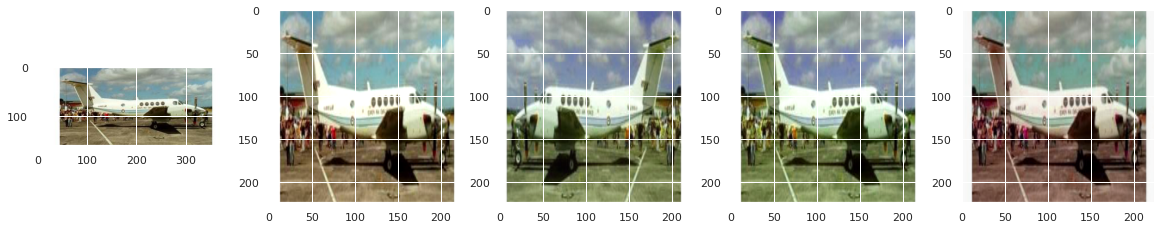

In [ ]:
def pil_loader(path):
	with open(path, 'rb') as f:
		img = Image.open(f)
		return img.convert('RGB')
image = "Caltech101/101_ObjectCategories/airplanes/image_0021.jpg"

transform = transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(brightness=0.1, 
                                                        contrast=0.05, 
                                                        saturation=0.05, 
                                                        hue=0.1),
                                
                                transforms.CenterCrop(224),
                                #transforms.RandomRotation(20),

                                #transforms.ToTensor(),
                                #transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)
                                ])

#transform = transforms.Compose([transforms.Resize(256),
#                                transforms.Resize((256, 256)), 
#                                #transforms.RandomCrop(224),
#                                transforms.RandomHorizontalFlip(),
#                                transforms.RandomRotation(30),# expand=True, fill=25),
#                                transforms.Pad((100, 100, 100, 100), padding_mode='edge'),
#                                transforms.CenterCrop(224),
#                                transforms.ColorJitter(hue=.1, saturation=.05),
#                                ])

img = pil_loader(image)
fig, ax = plt.subplots(1, 5, figsize=(20, 100))
ax[0].imshow(img)
for i in range(1, 5):
    ax[i].imshow(transform(img))

### 5.1 RandomHorizontalFlip + Color Jitter



In [ ]:
train_transform_DA1 = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(brightness=0.1, 
                                                        contrast=0.05, 
                                                        saturation=0.05, 
                                                        hue=0.1),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
# Define transforms for the evaluation phase
eval_transform_DA = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.CenterCrop(224),                                   
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
dataloader["train"].dataset.transform = train_transform_DA1
dataloader["val"].dataset.transform = eval_transform_DA
test_dataloader.dataset.transform = eval_transform_DA

In [ ]:
configs = {'fine_tuning':{"sgd":{'lr':5e-3, 'wd':5e-4},
                           "nag":{'lr':5e-3, 'wd':5e-5},
                           "adamw":{'lr':1e-4, 'wd':5e-5}},# "adamw":{'lr':5e-5, 'wd':5e-4}}, 
            'feat_extr': {"sgd":{'lr':5e-3, 'wd':5e-3},
                           "nag":{'lr':1e-2, 'wd':5e-3},
                           "adamw":{'lr':5e-5, 'wd':5e-4}}}
step_size = 15
gamma = 0.5
MOMENTUM = 0.9

for k, v in configs.items():
    print(f"{k}")
    for k1, v1 in v.items():
        print(k1, v1)
        net = alexnet(pretrained=True) # Loading AlexNet model
        if k == 'fine_tuning':
            net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
        elif k == 'feat_extr':
            for param in net.parameters():
                param.requires_grad = False
            for param in net.classifier.parameters():
                param.requires_grad = True
            net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
        
        # Define loss function
        criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
        parameters_to_optimize = net.parameters()
        if k1 == 'sgd':
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=v1['lr'], 
                                momentum=MOMENTUM, 
                                weight_decay=v1['wd'],
                                nesterov = True)
        elif k1 == 'nag':
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=v1['lr'], 
                                momentum=MOMENTUM, 
                                weight_decay=v1['wd'],
                                nesterov = True)
        elif k1 == 'adamw':
            optimizer = optim.AdamW(net.parameters(), 
                            lr= v1['lr'],
                            #amsgrad=True,
                            weight_decay=v1['wd'])
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        config = {'optimizer': optimizer, 
            'scheduler': scheduler, 
            'criterion': criterion, 
            'num_epochs': NUM_EPOCHS, 
            'device': 'cuda'}

        model, train_logs, val_logs = train_model(net,
                                dataloader,
                                config
                                )
        res = {'train': train_logs, 'val':val_logs}
        save_results(res, os.path.join('./drive/MyDrive/HW2/', f"5_1_{k}_{k1}.csv"))
        t_acc = evaluate_test_set(model, test_dataloader)
        print(t_acc)
        print(f"Test Accuracy: {t_acc}")
        print()
        print()

        
        

        

fine_tuning
sgd {'lr': 0.005, 'wd': 0.0005}


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Epoch 1/30 lr : [0.005]
train	Loss:  3.1644	Acc:  0.3140
val	Loss:  1.8442	Acc:  0.5951
new best val loss  1.8442  (acc =  0.5951)

Epoch 2/30 lr : [0.005]
train	Loss:  1.1310	Acc:  0.6954
val	Loss:  0.7755	Acc:  0.7974
new best val loss  0.7755  (acc =  0.7974)

Epoch 3/30 lr : [0.005]
train	Loss:  0.4188	Acc:  0.8548
val	Loss:  0.6309	Acc:  0.8347
new best val loss  0.6309  (acc =  0.8347)

Epoch 4/30 lr : [0.005]
train	Loss:  0.2239	Acc:  0.9039
val	Loss:  0.6197	Acc:  0.8413
new best val loss  0.6197  (acc =  0.8413)

Epoch 5/30 lr : [0.005]
train	Loss:  0.1226	Acc:  0.9371
EarlyStopping counter: 1 out of 5
val	Loss:  0.6391	Acc:  0.8513

Epoch 6/30 lr : [0.005]
train	Loss:  0.0748	Acc:  0.9519
EarlyStopping counter: 2 out of 5
val	Loss:  0.6651	Acc:  0.8385

Epoch 7/30 lr : [0.005]
train	Loss:  0.0532	Acc:  0.9595
EarlyStopping counter: 3 out of 5
val	Loss:  0.6748	Acc:  0.8496

Epoch 8/30 lr : [0.005]
train	Loss:  0.0412	Acc:  0.9623
EarlyStopping counter: 4 out of 5
val	Loss:  

### 5.2 RandoMHorizontalFlip + RandomRotation

In [ ]:
train_transform_DA2 = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
# Define transforms for the evaluation phase
eval_transform_DA = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.CenterCrop(224),                                   
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
dataloader["train"].dataset.transform = train_transform_DA2
dataloader["val"].dataset.transform = eval_transform_DA
test_dataloader.dataset.transform = eval_transform_DA

In [ ]:
configs = {'fine_tuning':{"sgd":{'lr':5e-3, 'wd':5e-4},
                           "nag":{'lr':5e-3, 'wd':5e-5},
                           "adamw":{'lr':1e-4, 'wd':5e-5}}, 
            'feat_extr': {"sgd":{'lr':5e-3, 'wd':5e-3},
                           "nag":{'lr':1e-2, 'wd':5e-3},
                           "adamw":{'lr':5e-5, 'wd':5e-3}}}
step_size = 15
gamma = 0.5
MOMENTUM = 0.9

for k, v in configs.items():
    print(f"{k}")
    for k1, v1 in v.items():
        print(k1, v1)
        net = alexnet(pretrained=True) # Loading AlexNet model
        if k == 'fine_tuning':
            net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
        elif k == 'feat_extr':
            for param in net.parameters():
                param.requires_grad = False
            for param in net.classifier.parameters():
                param.requires_grad = True
            net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
        
        # Define loss function
        criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
        parameters_to_optimize = net.parameters()
        if k1 == 'sgd':
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=v1['lr'], 
                                momentum=MOMENTUM, 
                                weight_decay=v1['wd'],
                                nesterov = True)
        elif k1 == 'nag':
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=v1['lr'], 
                                momentum=MOMENTUM, 
                                weight_decay=v1['wd'],
                                nesterov = True)
        elif k1 == 'adamw':
            optimizer = optim.AdamW(net.parameters(), 
                            lr= v1['lr'],
                            #amsgrad=True,
                            weight_decay=v1['wd'])
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        config = {'optimizer': optimizer, 
            'scheduler': scheduler, 
            'criterion': criterion, 
            'num_epochs': NUM_EPOCHS, 
            'device': 'cuda'}

        model, train_logs, val_logs = train_model(net,
                                dataloader,
                                config
                                )
        res = {'train': train_logs, 'val':val_logs}
        save_results(res, os.path.join('./drive/MyDrive/HW2/', f"5_2_{k}_{k1}.csv"))
        t_acc = evaluate_test_set(model, test_dataloader)
        print(t_acc)
        print(f"Test Accuracy: {t_acc}")
        print()
        print()


fine_tuning
sgd {'lr': 0.005, 'wd': 0.0005}
Epoch 1/30 lr : [0.005]
train	Loss:  3.3169	Acc:  0.2777
val	Loss:  2.0381	Acc:  0.5425
new best val loss  2.0381  (acc =  0.5425)

Epoch 2/30 lr : [0.005]
train	Loss:  1.3540	Acc:  0.6521
val	Loss:  0.9375	Acc:  0.7545
new best val loss  0.9375  (acc =  0.7545)

Epoch 3/30 lr : [0.005]
train	Loss:  0.6028	Acc:  0.8074
val	Loss:  0.7538	Acc:  0.8084
new best val loss  0.7538  (acc =  0.8084)

Epoch 4/30 lr : [0.005]
train	Loss:  0.3417	Acc:  0.8793
val	Loss:  0.7003	Acc:  0.8171
new best val loss  0.7003  (acc =  0.8171)

Epoch 5/30 lr : [0.005]
train	Loss:  0.2172	Acc:  0.9080
val	Loss:  0.6959	Acc:  0.8278
new best val loss  0.6959  (acc =  0.8278)

Epoch 6/30 lr : [0.005]
train	Loss:  0.1395	Acc:  0.9274
EarlyStopping counter: 1 out of 5
val	Loss:  0.7463	Acc:  0.8257

Epoch 7/30 lr : [0.005]
train	Loss:  0.1235	Acc:  0.9340
EarlyStopping counter: 2 out of 5
val	Loss:  0.7321	Acc:  0.8344

Epoch 8/30 lr : [0.005]
train	Loss:  0.1071	Acc:  

### 5.3 Color Jitter + Random Horizontal Flip + Random Rotation

In [ ]:
train_transform_DA3 = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ColorJitter(brightness=0.1, 
                                                        contrast=0.05, 
                                                        saturation=0.05, 
                                                        hue=0.1),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([#transforms.RandomCrop(100),
                                     transforms.Resize((256, 256)),
                                     transforms.CenterCrop(224),                                   
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)                                    
])

dataloader['train'].dataset.transform = train_transform_DA3
dataloader['val'].dataset.transform = eval_transform
test_dataset.transform = eval_transform

print(test_dataloader.dataset.transform)
print(dataloader['train'].dataset.transform)
print(dataloader['val'].dataset.transform)

Compose(
    Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Compose(
    Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [ ]:
configs = {'fine_tuning':{"sgd":{'lr':5e-3, 'wd':5e-4},
                           "nag":{'lr':5e-3, 'wd':5e-5},
                           "adamw":{'lr':1e-4, 'wd':5e-5}}, 
            'feat_extr': {"sgd":{'lr':5e-3, 'wd':5e-3},
                           "nag":{'lr':1e-2, 'wd':5e-3},
                           "adamw":{'lr':5e-5, 'wd':5e-3}}}
step_size = 15
gamma = 0.5
MOMENTUM = 0.9

for k, v in configs.items():
    print(f"{k}")
    for k1, v1 in v.items():
        print(k1, v1)
        net = alexnet(pretrained=True) # Loading AlexNet model
        if k == 'fine_tuning':
            net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
        elif k == 'feat_extr':
            for param in net.parameters():
                param.requires_grad = False
            for param in net.classifier.parameters():
                param.requires_grad = True
            net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
        
        # Define loss function
        criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
        parameters_to_optimize = net.parameters()
        if k1 == 'sgd':
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=v1['lr'], 
                                momentum=MOMENTUM, 
                                weight_decay=v1['wd'],
                                nesterov = True)
        elif k1 == 'nag':
            optimizer = optim.SGD(parameters_to_optimize, 
                                lr=v1['lr'], 
                                momentum=MOMENTUM, 
                                weight_decay=v1['wd'],
                                nesterov = True)
        elif k1 == 'adamw':
            optimizer = optim.AdamW(net.parameters(), 
                            lr= v1['lr'],
                            #amsgrad=True,
                            weight_decay=v1['wd'])
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        config = {'optimizer': optimizer, 
            'scheduler': scheduler, 
            'criterion': criterion, 
            'num_epochs': NUM_EPOCHS, 
            'device': 'cuda'}

        model, train_logs, val_logs = train_model(net,
                                dataloader,
                                config
                                )
        res = {'train': train_logs, 'val':val_logs}
        save_results(res, os.path.join('./drive/MyDrive/HW2/', f"5_3_{k}_{k1}.csv"))
        t_acc = evaluate_test_set(model, test_dataloader)
        print(t_acc)
        print(f"Test Accuracy: {t_acc}")
        print()
        print()

        
        

        

fine_tuning
sgd {'lr': 0.005, 'wd': 0.0005}
Epoch 1/30 lr : [0.005]
train	Loss:  3.1828	Acc:  0.3012
val	Loss:  2.1872	Acc:  0.5259
new best val loss  2.1872  (acc =  0.5259)

Epoch 2/30 lr : [0.005]
train	Loss:  1.3369	Acc:  0.6466
val	Loss:  1.1291	Acc:  0.7182
new best val loss  1.1291  (acc =  0.7182)

Epoch 3/30 lr : [0.005]
train	Loss:  0.4956	Acc:  0.8285
val	Loss:  1.0342	Acc:  0.7344
new best val loss  1.0342  (acc =  0.7344)

Epoch 4/30 lr : [0.005]
train	Loss:  0.2611	Acc:  0.8997
val	Loss:  0.9875	Acc:  0.7479
new best val loss  0.9875  (acc =  0.7479)

Epoch 5/30 lr : [0.005]
train	Loss:  0.1146	Acc:  0.9426
EarlyStopping counter: 1 out of 5
val	Loss:  1.0249	Acc:  0.7510

Epoch 6/30 lr : [0.005]
train	Loss:  0.0788	Acc:  0.9516
EarlyStopping counter: 2 out of 5
val	Loss:  0.9974	Acc:  0.7673

Epoch 7/30 lr : [0.005]
train	Loss:  0.0547	Acc:  0.9582
EarlyStopping counter: 3 out of 5
val	Loss:  1.0055	Acc:  0.7714

Epoch 8/30 lr : [0.005]
train	Loss:  0.0451	Acc:  0.9592
Ea

## 6. Beyond AlexNet

### 6.A VGG

In [ ]:
!main.py

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 6.B ResNet

In [ ]:
!main-2.py